In [1]:
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# custom packages
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from utils import *
from estimators import ClusteredSegmentation
from BarcodeScanner import barcodeScanner
# scipy
import scipy
from scipy.sparse import vstack, identity, csr_array, vstack, csc_matrix
from scipy.sparse.linalg import svds, inv
from scipy.stats import f, ncf
from scipy.spatial.distance import mahalanobis, euclidean
# sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# others
from tqdm.notebook import trange
from itertools import combinations, starmap
from functools import partial

In [2]:
rg = RandomGenerator(4, 5_000, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20, random_state = 1)
cluster = ClusteredSegmentation(n_clusters = 4)
cluster.fit(X_train, y_train)
tau = cluster.tau_metric
y_pred_exist = []
y_test_exist = []
for i, x in enumerate(X_test.reshape(-1)):
    try:
        y_pred_exist.append(cluster.predict(x))
        y_test_exist.append(y_test[i][0])
    except:
        pass
test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)
tau.r_sqf, tau.r_sqr, test_r2, tau.tau_est, tau.tau_LB

(0.698257768900144,
 0.6818997226460326,
 0.6872395759336448,
 0.05421198814128879,
 0.0398415817561444)

In [3]:
cluster.clusterer_.children_

array([[   0,   41],
       [   1,    2],
       [   3, 4001],
       ...,
       [7989, 7995],
       [7994, 7996],
       [7993, 7997]])

In [4]:
y_train[cluster.clusterer_.children_[5],:]

IndexError: index 4003 is out of bounds for axis 0 with size 4000

In [ ]:
cluster.clusterer_.compute_full_tree()

C space -> C^T (CC^T)-1 C <- proj_C    P LAmb PT

# Barcode

In [5]:
from scipy.linalg import qr

In [6]:
scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<12x16 sparse matrix of type '<class 'numpy.int8'>'
 	with 50 stored elements in Compressed Sparse Row format>,
 None)

In [7]:
count_non_zero = []
for i in range(scanner.raw_contrast.shape[0]):
    c = scanner.raw_contrast.getrow(i).count_nonzero()
    count_non_zero.append(c)

/Users/gradcheckout/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


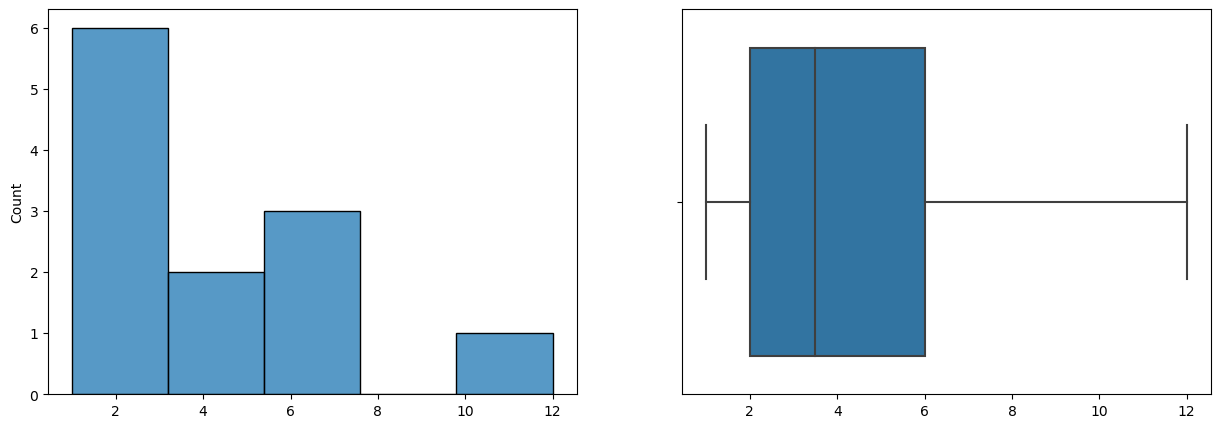

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.histplot(count_non_zero, ax = ax1)
sns.boxplot(count_non_zero, ax = ax2)
plt.show()

In [9]:
contrasts = vstack([scanner.raw_contrast, scanner.missingPairsMLE()]).astype(np.float64)
q, r = qr(contrasts.T.toarray()) # QR decomposition of 1024 x 1014
NULL = q[:, :12]
PARAM = q[:,12:] # selection of orthonormal basis spanning null space
P_p = PARAM@PARAM.T # projection matrix to the parameter space
P_n = NULL @ NULL.T # projection matrix to the null space
identity_csc = identity(2**4) # defining identity matrix
VI_p =  (identity_csc - P_p)
VI_n = (identity_csc - P_n)

## Method 1: Forward Selection

In [10]:
def find_max_index(selected, sign, size = 4, return_plot = True):
    tested_index  = []
    tested_sign   = []
    p_distance    = []
    null_distance = []
    array = np.zeros(2**size, dtype = np.byte)
    positive_selected = [x for x, y in zip(selected, sign) if y == 1]
    negative_selected = [x for x, y in zip(selected, sign) if y == -1]
    array[positive_selected] = 1
    array[negative_selected] = -1

    for i in range(2**size):
        if i in selected:
            pass
        else:
            test_array = array.copy()
            tested_sign.append(1)
            tested_index.append(i)
            test_array[i] = 1
            l2_norm = np.sqrt(sum([abs(x) for x in test_array]))
            normed_test_array = test_array/l2_norm

            p_distance.append((normed_test_array @ VI_p @ normed_test_array.T)[0,0])
            null_distance.append((normed_test_array @ VI_n @ normed_test_array.T)[0,0])

            tested_sign.append(-1)
            tested_index.append(i)
            test_array[i] = -1
            normed_test_array = test_array/l2_norm
            p_distance.append((normed_test_array @ VI_p @ normed_test_array.T)[0,0])
            null_distance.append((normed_test_array @ VI_n @ normed_test_array.T)[0,0])
    df = pd.DataFrame(zip(tested_index, tested_sign, p_distance, null_distance), columns = ['var_selected', 'sign','p_distance','null_distance'])
    if return_plot:
        sns.scatterplot(data = df, x = 'p_distance',y = 'null_distance', hue = 'sign')
        plt.show()
    return df.sort_values('null_distance').reset_index(drop = True)

In [11]:
# selected = [x for x in range(11)]
# sign     = [1 for x in range(11)]
selected = [0]
sign = [1]

In [12]:
# result = find_max_index(selected, sign, return_plot = False)
# result

In [13]:
# selected += [1, 2, 3, 4]
# sign += [-1, 1, 1, 1]

In [14]:
for _ in range(6):
    result = find_max_index(selected, sign, return_plot = False).tail(1).values[0]
    selected += [int(result[0])]
    sign += [result[1]]

In [15]:
selected

[0, 10, 4, 14, 15, 8, 2]

In [16]:
p_distance_forward = result[2]
null_distance_forward = result[3]

In [17]:
p_distance_forward, null_distance_forward

(0.11520737327188948, 0.8847926267281105)

#### True model vs Variable Selection by ClusterEstimator

In [18]:
df = rg._X.copy()

#### 1. True Model

In [19]:
rg.config.coefficients

{'X_0': -1.6745377957339609,
 'X_1': 6.1393880960682825,
 'X_2': 6.198902629282587,
 'X_3': -7.086017900547954,
 'X_1X_2': 10.854550295034176,
 'X_1X_3': -6.895957043885426,
 'X_2X_3': 4.106749285630218,
 'X_0X_1X_2': 1.9547654475934753,
 'X_0X_2X_3': 9.403922374360903,
 'X_0X_1X_3': -2.83689264827225,
 'intercept': 8.386934961526222}

In [20]:
selected = [0] + [scanner.var_names_all.index(key)+ 1 for key, val in rg.config.coefficients.items() if key != 'intercept']
sign = [1, 1, 1, 1, 1, 1, 1]
array = np.zeros(2**4, dtype = np.byte)
positive_selected = [x for x, y in zip(selected, sign) if y == 1]
negative_selected = [x for x, y in zip(selected, sign) if y == -1]
array[positive_selected] = 1
array[negative_selected] = -1


In [21]:
selected

[0, 1, 2, 3, 4, 8, 9, 10, 11, 13, 12]

In [22]:
norm_array = array/np.sqrt(len(selected))

In [23]:
p_distance_true = (norm_array @ VI_p @ norm_array.T)[0,0]
null_distance_true = (norm_array @ VI_n @ norm_array.T)[0,0]

In [24]:
p_distance_true, null_distance_true

(0.4574780058651027, 0.1788856304985338)

In [25]:
df['X_1X_2'] = df.X_1 * df.X_2
df['X_0X_1X_3'] = df.X_0 * df.X_1 * df.X_3

In [26]:
X = df.loc[X_train.index, df.columns.str.contains('X')]

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [27]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [5000, 4000]

In [619]:
reg.intercept_, reg.coef_

(3.5904399293820894,
 array([13.68156597,  8.76797477,  8.4742376 ,  3.11516569, 11.89542357,
         6.57897322]))

In [620]:
rg.config.coefficients

{'X_0': 13.80846513238334,
 'X_1': 9.002660155592665,
 'X_2': 8.511688459948779,
 'X_3': 3.8099117917375045,
 'X_1X_2': 11.751434349909433,
 'X_0X_1X_3': 5.447608269998005,
 'intercept': 3.3385569246056956}

#### Variable Selection Model